# Practical: Cubic Equations of State 

### Plotting PV diagram of pure ${\mathrm{CO}_2}$ with a cubic EoS (SRK)

VT props progress: finished0 idxs: [999   3] state: [0.0021, 313.0, 1.0][197   2] state: [0.0004, 303.0, 1.0]


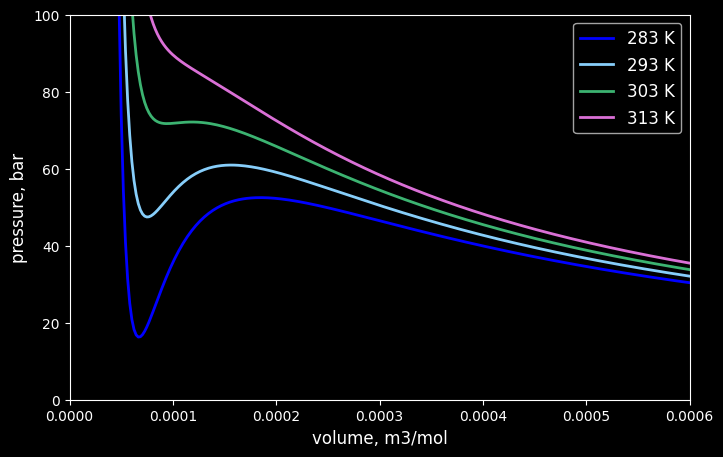

In [8]:
import numpy as np
from dartsflash.dartsflash import DARTSFlash, CompData
from dartsflash.libflash import CubicEoS
from numba.np.arraymath import npy_max

# Define mixture and initialize Flash object
comp_data = CompData(components=["CO2"], setprops=True)
f=DARTSFlash(comp_data=comp_data)

# Add CubicEoS object
f.add_eos("CEOS", CubicEoS(comp_data, CubicEoS.PR))
ceos = f.eos["CEOS"]

# Define range of molar volumes for x-axis
Vmax = ceos.V(p=10, T=273.15, n=[1.])
Vmin = ceos.V(p=200, T=273.15, n=[1.])

# Define state specification, compositions and properties to evaluate
state_spec = {"volume": np.linspace(Vmin, Vmax, 1000),
              "temperature": np.array([283, 293, 303, 313]),
             }
compositions = {"CO2": 1.}
dims_order = ["volume", "temperature"]
properties = {"P": ceos.P,
              "Z": ceos.Z,
             }

# Calculate pressure at each (T,V)
vt_props = f.evaluate_phase_properties_1p(state_spec=state_spec, compositions=compositions,
                                    properties_to_evaluate=properties, mole_fractions=True, print_state="VT props")

# Plot P-V diagram
from dartsflash.plot import PlotEoS
pv_plot = PlotEoS.pressure_volume(f, temperatures=state_spec["temperature"], compositions=[1.],
                                  p_props=None, v_props=vt_props, v_range=[0, 6e-4], p_range=[0, 100])

### <font color='blue'>Excersise 1: compute and plot solution when all 3 real roots are equal. Which thermodynamic state it is?

### Calculating the enthalpy of pure ${\mathrm{CO}_2}$ with a cubic EoS (SRK)

In [9]:
# Evaluate enthalpy and entropy of CO2
state_spec = {"temperature": np.arange(248, 348, 10),
              "pressure": np.array([25, 50, 75, 100]),
             }
compositions = {"CO2": 1.}
properties = {"H": ceos.H, "S": ceos.S}

results = f.evaluate_phase_properties_1p(state_spec=state_spec, compositions=compositions,
                                         properties_to_evaluate=properties, mole_fractions=True)


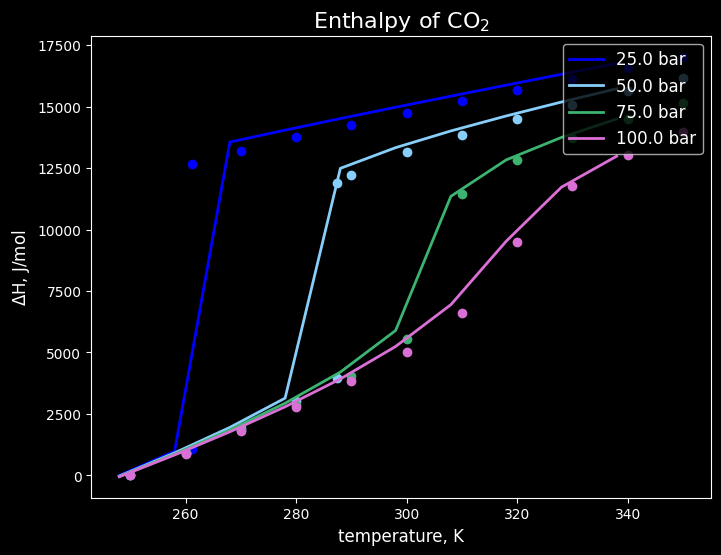

In [10]:
# Get NIST data and plot
from ref_data import get_nist_data

R = 8.3144772

num_curves = len(state_spec["pressure"])
ref_T, ref_H, ref_S = [np.ones(20) * np.nan for i in range(num_curves)], [np.ones(20) * np.nan for i in range(num_curves)], [np.ones(20) * np.nan for i in range(num_curves)]

for i, p in enumerate(state_spec["pressure"]):
    nist_data = get_nist_data(component="CO2", temperature=np.arange(250, 351, 10), pressure=p, include_phase_boundary=True)
    n_points = len(nist_data["temperature"])
    ref_T[i][:n_points] = nist_data["temperature"]
    ref_H[i][:n_points] = nist_data["enthalpy"]
    ref_S[i][:n_points] = nist_data["entropy"]

for i in range(num_curves):
    H0 = ref_H[i][0]
    ref_H[i][:] = [(Hj - H0) * 1e3 for Hj in ref_H[i][:]]  # set reference value of enthalpy and convert kJ/mol to J/mol
    S0 = ref_S[i][0]
    ref_S[i][:] = [(Sj - S0) * 1e3 for Sj in ref_S[i][:]]  # set reference value of entropy and convert kJ/mol to J/mol

T = state_spec["temperature"]
H0 = results.isel(pressure=0).H.values[0]  # set reference value of enthalpy at first value
H = [(results.isel(pressure=i).H.values - H0) * R for i, pres in enumerate(state_spec["pressure"])]
S0 = results.isel(pressure=0).S.values[0]  # set reference value of entropy at first value
S = [(results.isel(pressure=i).S.values - S0) * R * 1e3 for i, pres in enumerate(state_spec["pressure"])]
labels = ["{:.1f} bar".format(pres) for pres in state_spec["pressure"]]

from dartsflash.diagram import Diagram
H_plot = Diagram()
H_plot.draw_line(X=T, Y=H, datalabels=labels)
H_plot.draw_point(X=ref_T, Y=ref_H)
H_plot.add_attributes(title="Enthalpy of " + f.mixture_name, ax_labels=["temperature, K", r"$\Delta$H, J/mol"], legend=True)

### <font color='blue'>Excersise 2: plot solutions for pressure 75 and 100 bars. What is the temperature of vaporization for all 4 pressures?

### Enthalpy diagram of pure ${\mathrm{CO}_2}$ with a cubic EoS (SRK)

In [11]:
R = 8.3144772  # gas constant

# Define mixture and initialize Flash object
comp_data = CompData(components=["CO2"], setprops=True)
f = DARTSFlash(comp_data=comp_data)

# Add CubicEoS object
f.add_eos("CEOS", CubicEoS(comp_data, CubicEoS.PR))
ceos = f.eos["CEOS"]

# Plot enthalpy diagram
state_spec = {"temperature": np.arange(273, 423, 1),
              "pressure": np.arange(1, 200, 1),
             }
compositions = {"CO2": 1.}
properties = {"H": ceos.H,
              "JT": ceos.JT,
             }

pt_props = f.evaluate_phase_properties_1p(state_spec=state_spec, compositions=compositions,
                                    properties_to_evaluate=properties, mole_fractions=True)

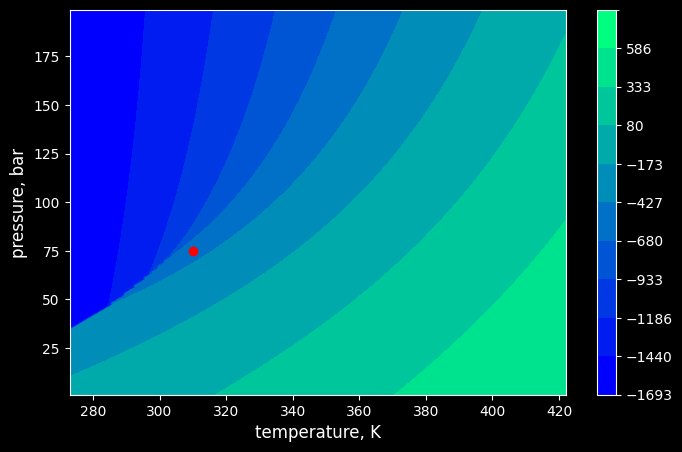

In [12]:
# Plot PT diagram of CO2 enthalpy
from dartsflash.plot import PlotEoS
pt = PlotEoS.surf(f, pt_props, x_var="temperature", y_var="pressure", prop_names=["H"], composition=[1.])
pt.draw_point(X=310, Y=75, colours='red')  # Critical point

pt.add_attributes(ax_labels=["temperature, K", "pressure, bar"])

### <font color='blue'>Excersise 3: add two more points for T = 310 K and p = 50 and 100 bars. Explain why enthalpy is changing this way.

### Studying isenthalpic cooling of pure ${\mathrm{CO}_2}$

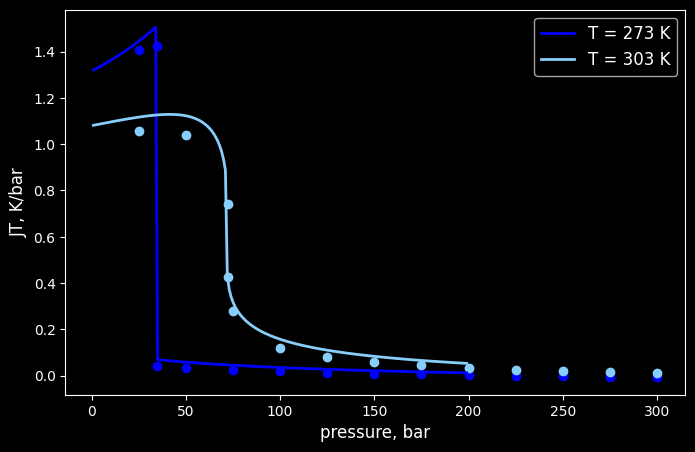

In [13]:
# Get reference data from NIST
from ref_data import get_nist_data

temperatures = np.array([0., 30.]) + 273.15
ref_p, ref_JT = [[] for i, temp in enumerate(temperatures)], [[] for i, temp in enumerate(temperatures)]
for i, t in enumerate(temperatures):
    nist_data = get_nist_data(component="CO2", temperature=t, 
                              pressure=np.arange(25, 301, 25), include_phase_boundary=True)

    ref_p[i] = nist_data["pressure"]
    ref_JT[i] = nist_data["jt"]

# Joule-Thomson coefficient CO2
from dartsflash.plot import PlotEoS
jt = PlotEoS.plot(f, pt_props, composition=[1.], x_var="pressure", prop_names=["JT"],
                  state={"temperature": temperatures}, datalabels=["T = {:.0f} K".format(t) for t in temperatures])

jt.draw_point(X=ref_p, Y=ref_JT)
jt.add_attributes(ax_labels=["pressure, bar", "JT, K/bar"], legend=True)

### <font color='blue'>Excersise 4: plot cooling curves for T = 323 and 343 with the same pressure drop from 200 to 40 bars.

### Getting the density of a ${\mathrm{CO}_2}$-${\mathrm{CH}_4}$ mixture

In [14]:

import numpy as np
import xarray as xr

from dartsflash.libflash import FlashParams, EoSParams, EoS, InitialGuess
from dartsflash.libflash import Flash
from dartsflash.libflash import CubicEoS

from dartsflash.dartsflash import DARTSFlash, CompData
from dartsflash.mixtures import VL

components = ["CO2", "C1"]
comp_data = CompData(components, setprops=True)
f = VL(comp_data=comp_data)

f.set_vl_eos("PR", trial_comps=[0, 1],
             root_order=[EoS.MAX, EoS.MIN],
             # rich_phase_order=[0, -1],  # will sort rich liquid phases according to component index. In this case: [CO2-rich liquid, other liquid]
            )
ceos = f.eos["VL"]

f.init_flash(flash_type=DARTSFlash.FlashType.PTFlash)
""" Define state specifications and compositions """
dz = 0.01
min_z = [0.9]
max_z = [1.]
compositions = {"CO2": np.arange(min_z[0], max_z[0]+dz*0.1, dz),
                "C1": 1.,
               }
state_spec = {"pressure": np.arange(10, 200, 1),
              "temperature": np.arange(273.15, 423.15, 1),
              }

""" Perform flash calculations """
flash_results = f.evaluate_flash(state_spec=state_spec, compositions=compositions, mole_fractions=True)

In [15]:
# Density Px CO2/CO2-C1
P = state_spec["pressure"]


### <font color='blue'>Excersise 5: explain why density is dropping by going from right to left. Why it is changing at low pressure?